# Classes of cities -- clustering analysis

This notebook presents an analysis of cities using remote-sensing data on macro-level socio-demographic indicators. In particular, we characterize cities by the dependence with distance (from the city center) of several macroeconomic quantities:
* built areas $x_{bldg}(d)$ estimated from SAR/GUF data
* population density $x_{pop}(d)$ estimated from LandScan data
* luminosity $x_{lum}(d)$ estimated from VIIRS (nightlights) data.

We model each quantity (population, luminosity, built area) by breaking it down into a scale component and a spatial profile component:

<p><center> $\displaystyle x(d) = c \cdot \hat{x}(d)$ </center></p>

We analyze cities from the perspective of patterns in each of the components $c$ and $\hat{x}(\cdot)$. We'll have one such set of objects for each data source we consider (population, luminosity, building density).

We expect (as shown empirically below) that the distribution of the scale factor $c$ across cities is heavily skewed towards small $c$, and is approximately a log-normal. 

At the same time, prior research on urban form typically models the relationship of $x (d)$ with distance $d$ using an exponential form:

<p><center> $\displaystyle x(d) = x_0 e^{-\gamma d}$ </center></p>

Above, $\gamma$ is the _average (radial) spatial gradient_ which previous studies (e.g., Alain Bertaud's work) have investigated. This can be estimated readily via linear regression:

<p><center> $\displaystyle \text{log } x(d) = \text{log } x_0 -\gamma d$ </center></p>

(Note we will use 10-base logarithm, but still refer to it as _log_ for ease of notation.)

The two expressions for $x(d)$ are equivalent, so $c$ could be identified as $\text{log }x_0$, but we'll prefer to retain the scale factor $c$, because it has a more direct interpretation. 





# Packages

In [460]:
import numpy as np
import pandas as pd

import geopandas as gpd
import shapely.wkt
from shapely import geometry
import re

import sys, os, time
import glob

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave

import warnings
warnings.filterwarnings('ignore')

import gzip
import cPickle as pickle
import copy

colormap = {"bldg":"black", "pop":"green", "lum":"orange", "all":"blue"}

cmap_bld = sns.light_palette("black", n_colors=5)
cmap_pop = sns.light_palette("green", n_colors=5)
cmap_lum = sns.light_palette("orange",n_colors=5)


cmap_dict = {"bldg":ListedColormap(cmap_bld), 
             "pop":ListedColormap(cmap_pop), 
             "lum":ListedColormap(cmap_lum)}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load city feature data for analysis

In [2]:
dataroot = "/home/data/world-cities/"

#### Data on raw variable profiles with distance

In [427]:
# load pre-computed profile data

with gzip.open(dataroot + "stats_25k_cities_raw.pickle.gz", "r") as f:
    cities = pickle.load(f)
  
cities_sel_df = pd.read_csv(dataroot + "/selected_urban_areas.csv")
cities_sel_df['geometry'] = cities_sel_df['geometry'].apply(lambda s: shapely.wkt.loads(s))

# select cities obtained after spatial pruning 
cities_sel = {k:v for k,v in cities.iteritems() if (v['city'] in cities_sel_df['City'].values.tolist())}

# select cities with at least 5% built area
# cities_sel = {k:v for k,v in cities.iteritems() if (v['avg area']['bldg']>=0.05)}

In [5]:
print len(cities), len(cities_sel)

24462 2526


# Illustrate several cities of interest

#### Examples of spatial profiles to describe cities

In [299]:
xtick_labels = ((10*200./286)*np.arange(20)).astype(int)

smpl_cities = ["paris, fr", "boston, us", "san francisco, us", "new delhi, in", "shanghai, cn", "lagos, ng"]
smpl = {k:v for k,v in cities_sel.iteritems() 
        if len([x for x in smpl_cities if len(v['city'].split("(")[0][:-1].replace(x,""))==0])>0}

colormap_cities = dict(zip(smpl.keys(), sns.color_palette()))

#### Raw profiles and average spatial gradient estimation

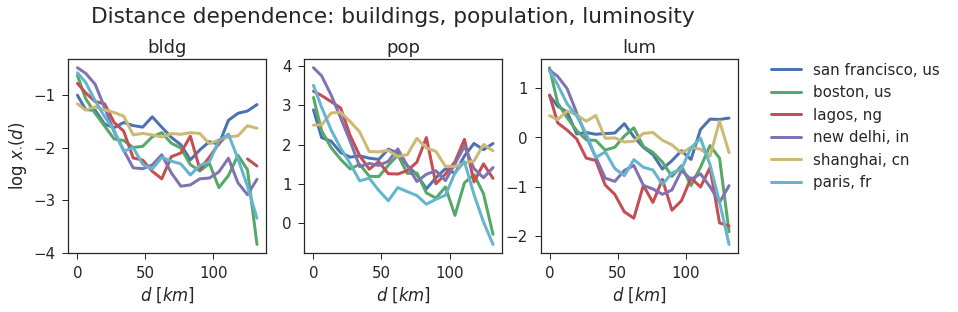

In [155]:
sns.set_context("notebook", font_scale=1.5)
fig, ax = plt.subplots(1,3, figsize=(12,4), gridspec_kw={"wspace":0.195, "hspace":0.5},
                      sharex=True, sharey=False)

for j,s,a in zip(range(len(smpl)),['bldg', 'pop', 'lum'],ax.flatten()):
    for k,v in smpl.iteritems():
        mu = v['profiles'][s][0]
        a.plot(xtick_labels, np.log10(mu), lw=3, 
               label=v['city'].split("(")[0])
    a.set_title(s)
    if j == 0:
        a.set_ylabel("log $x_{\cdot}(d)$")
    a.set_xlabel("$d \ [km]$")
 
a.legend(loc="best", bbox_to_anchor=(1.1, 1.05))
fig.subplots_adjust(top=0.8)
plt.suptitle("Distance dependence: buildings, population, luminosity")

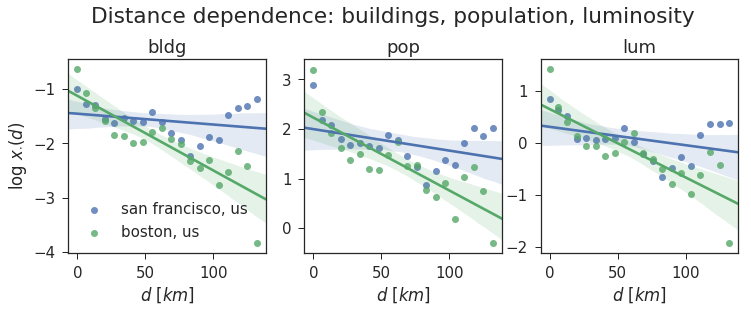

In [298]:
sns.set_context("notebook", font_scale=1.5)
fig, ax = plt.subplots(1,3, figsize=(12,4), gridspec_kw={"wspace":0.195, "hspace":0.5},
                      sharex=True, sharey=False)

for j,s,a in zip(range(len(smpl)),['bldg', 'pop', 'lum'],ax.flatten()):
    for i,k in enumerate(smpl.keys()[:2]):
        v = smpl[k]
        mu = v['profiles'][s][0]
        sns.regplot(xtick_labels, np.log10(mu), ax=a,  
                   label=v['city'].split("(")[0], color=colormap_cities[k])
        a.set_title(s)
    if j == 0:
        a.set_ylabel("log $x_{\cdot}(d)$")
        a.legend(loc="best")# bbox_to_anchor=(1.1, 1.05))
    a.set_xlabel("$d \ [km]$")
 
fig.subplots_adjust(top=0.8)
plt.suptitle("Distance dependence: buildings, population, luminosity")

#### Normalized profiles

As the plots below show, it looks like there are some strong differences between (normalized) population, built environment, and luminosity (energy use/economic activity) for the example cities. Some cities like Lagos have spread out population, but lower luminosity and building density, whereas the population and luminosity for Boston are more or less in sync. 

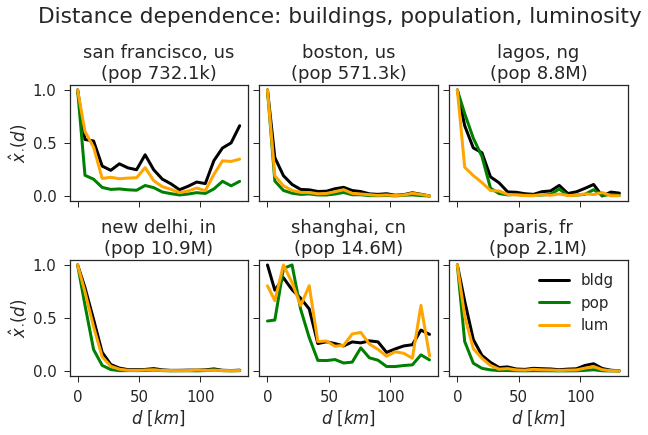

In [347]:
sns.set_context("notebook", font_scale=1.5)
fig, ax = plt.subplots(2,3, figsize=(10,6), gridspec_kw={"wspace":0.065, "hspace":0.5},
                      sharex=True, sharey=True)

for j,(k,v),a in zip(range(len(smpl)),smpl.iteritems(), ax.flatten()):
    for s in ['bldg', 'pop', 'lum']:
        mu = v['profiles'][s][0]
        scale = mu.max() #v['sum area'][s]
        a.plot(xtick_labels, mu / scale, lw=3, label=s, color=colormap[s])
    a.set_title(v['city'].replace(' (','\n('))
    if j % 3 == 0:
        a.set_ylabel("$\hat x_{\cdot}(d)$")
    if j in [3,4,5]:
        a.set_xlabel("$d \ [km]$")
        
a.legend(loc="best")
fig.subplots_adjust(top=0.8)
plt.suptitle("Distance dependence: buildings, population, luminosity")

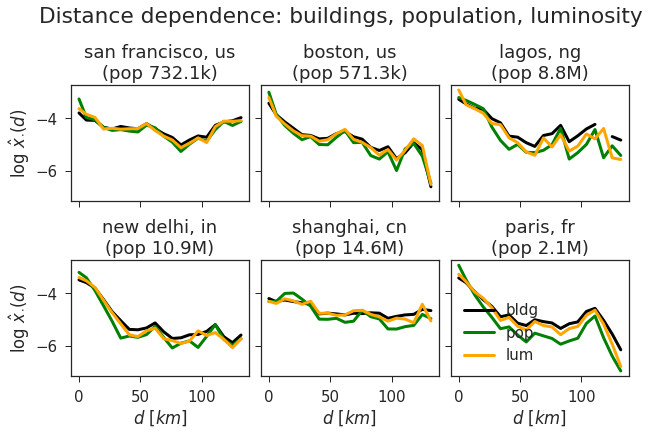

In [370]:
sns.set_context("notebook", font_scale=1.5)
fig, ax = plt.subplots(2,3, figsize=(10,6), gridspec_kw={"wspace":0.065, "hspace":0.5},
                      sharex=True, sharey=True)

for j,(k,v),a in zip(range(len(smpl)),smpl.iteritems(), ax.flatten()):
    for s in ['bldg', 'pop', 'lum']:
        mu = v['profiles'][s][0]
        scale = v['sum area'][s]
        a.plot(xtick_labels, np.log10(mu / scale), lw=3, label=s, color=colormap[s])
    a.set_title(v['city'].replace(' (','\n('))
    if j % 3 == 0:
        a.set_ylabel("log $\hat x_{\cdot}(d)$")
    if j in [3,4,5]:
        a.set_xlabel("$d \ [km]$")
        
a.legend(loc="best")
fig.subplots_adjust(top=0.8)
plt.suptitle("Distance dependence: buildings, population, luminosity")

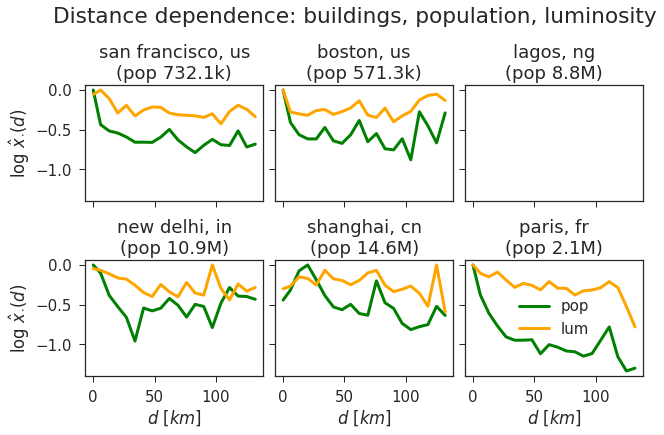

In [361]:
sns.set_context("notebook", font_scale=1.5)
fig, ax = plt.subplots(2,3, figsize=(10,6), 
                       gridspec_kw={"wspace":0.065, "hspace":0.5},
                       sharex=True, sharey=True)

for j,(k,v),a in zip(range(len(smpl)),smpl.iteritems(), ax.flatten()):
    for s in ['pop', 'lum']:
        mu = v['profiles'][s][0]
        bl = v['profiles']['bldg'][0]
        mu = mu / bl
        a.plot(xtick_labels, np.log10(mu / mu.max()), lw=3, label=s, color=colormap[s])
    a.set_title(v['city'].replace(' (','\n('))
    if j % 3 == 0:
        a.set_ylabel("log $\hat x_{\cdot}(d)$")
    if j in [3,4,5]:
        a.set_xlabel("$d \ [km]$")
        
a.legend(loc="best")
fig.subplots_adjust(top=0.8)
plt.suptitle("Distance dependence: buildings, population, luminosity")

But the curves $x_\cdot(d)$ above are the $\textit{average}$ profiles. The variance around these averages can be significant, as shown in the figures below. Note that the variance seems to increase with distance, which is to be expected, given that farther out from the city center there can be many different types of sprawl.

In [ ]:
sns.set_context("notebook", font_scale=1.5)
fig, ax = plt.subplots(2,3, figsize=(10,6), gridspec_kw={"wspace":0.065, "hspace":0.5},
                      sharex=True, sharey=True)

for j,(k,v),a in zip(range(len(smpl)),smpl.iteritems(), ax.flatten()):
    for s in ['bldg', 'pop', 'lum']:
        mu = v['profiles'][s][0]
        sd = v['profiles'][s][1]
        snr = sd / mu
        a.plot(xtick_labels, snr, lw=3, label=s, color=colormap[s])
#         a.fill_between(xtick_labels,
#                    np.minimum(mu-1.96*sd,0), 
#                    np.maximum(mu+1.96*sd,1), 
#                    color=colormap[s], alpha=0.3)
    a.set_title(v['city'].replace(' (','\n('))
    if j % 3 == 0:
        a.set_ylabel("$var[x] \ /\ E[x] (d)$")
    if j in [3,4,5]:
        a.set_xlabel("$d \ [km]$")
        
a.legend(loc="best")
fig.subplots_adjust(top=0.8)
plt.suptitle("Distance dependence: variance vs mean ratio")

# Format scale and profile data for analysis

#### Format scale data

In [381]:
scales = np.vstack([[v['sum area']['bldg'] for k,v in cities_sel.iteritems()],
                    [v['sum area']['pop'] for k,v in cities_sel.iteritems()],
                    [v['sum area']['lum'] for k,v in cities_sel.iteritems()]]).T
scales_df = pd.DataFrame(scales, columns=["bldg", "pop", "lum"])
info_df = pd.DataFrame(np.array(
                        [[v['city'] for k,v in cities_sel.iteritems()],
                        [v['class'] for k,v in cities_sel.iteritems()],
                        [v['region'] for k,v in cities_sel.iteritems()]]).T,
                      columns=['city', 'class', 'region'])
scales_df = pd.concat([info_df, scales_df], axis=1)

scales_df.head()

,city,class,region,bldg,pop,lum
0,"achalpur, in (pop 111.3k)",small-1,Asia,65.451806,8.130037e+05,2482.280702
1,"san carlos de bariloche, ar (pop 110.0k)",small-1,Americas,28.596960,6.867875e+04,1887.471910
2,"la ceiba, hn (pop 130.2k)",small-1,Americas,51.011415,3.435122e+05,1959.375000
3,"turhal, tr (pop 110.9k)",small-1,Asia,149.366752,7.842094e+05,11648.643478
4,"matsusaka, jp (pop 124.6k)",small-1,Asia,751.111747,3.675933e+06,26886.084821


Let's standardize the profiles by subtracting the mean and scaling by variance. This is to compare relative variation across cities between population, luminosity, and buildings.

In [374]:
from sklearn.preprocessing import StandardScaler

scales_std = StandardScaler().fit_transform(scales)
scales_std_df = pd.DataFrame(scales_std, columns=["bldg", "pop", "lum"])
scales_std_df = pd.concat([info_df, scales_std_df], axis=1)

Normalize the population and luminosity profiles by the building density profiles.

In [382]:
scales_norm = scales[:,1:3].copy()
scales_norm = scales_norm / scales[:,0,None]
scales_norm_df = pd.DataFrame(scales_norm, columns=["pop", "lum"])
scales_norm_df = pd.concat([info_df, scales_norm_df], axis=1)

#### Format spatial profile data

In [391]:
# extract profile data

Xbld = np.vstack([v['profiles']['bldg'][0] for k,v in cities_sel.iteritems()])
Xpop = np.vstack([v['profiles']['pop'][0] for k,v in cities_sel.iteritems()])
Xlum = np.vstack([v['profiles']['lum'][0] for k,v in cities_sel.iteritems()])
Xpop[np.isnan(Xpop)] = 0; Xlum[np.isnan(Xlum)] = 0; Xbld[np.isnan(Xbld)] = 0

# normalize profiles by the scale

Xbld_hat = Xbld / scales[:,0,None]
Xpop_hat = Xpop / scales[:,1,None]
Xlum_hat = Xlum / scales[:,2,None]

# Xpop_hat = Xpop / Xpop.max(1)[:,None]
# Xlum_hat = Xlum / Xlum.max(1)[:,None]
# Xbld_hat = Xbld / Xbld.max(1)[:,None]

# convert to logarithmic space

Xpop_hat_log = np.log10(Xpop_hat); 
Xlum_hat_log = np.log10(Xlum_hat); 
Xbld_hat_log = np.log10(Xbld_hat); 

Xall_hat_log = np.hstack([Xbld_hat_log, Xpop_hat_log, Xlum_hat_log])

# normalize by building density

Xbld[Xbld < 1e-4] = 0
Xpop_norm = np.log10(Xpop / Xbld); Xpop_norm[np.isneginf(Xpop_norm) | np.isinf(Xpop_norm)] = 0
Xlum_norm = np.log10(Xlum / Xbld); Xlum_norm[np.isneginf(Xlum_norm) | np.isinf(Xlum_norm)] = 0
Xpop_norm[np.isnan(Xpop_norm)] = 0; Xlum_norm[np.isnan(Xlum_norm)] = 0; 
Xall_norm = np.hstack([Xpop_norm, Xlum_norm])

# Analyze scales: population, luminosity, built area


#### How do the scales vary across cities / regions?

First, let's look at raw scales (in log-space to aid visual comparison).

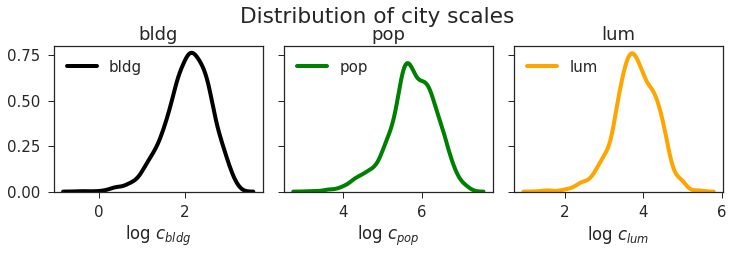

In [383]:
sns.set_context("notebook", font_scale=1.5)

fig, ax = plt.subplots(1,3, figsize=(12,3),
                      gridspec_kw={"wspace":0.1, "hspace":0.25},
                      sharex=False, sharey=True)

for a,c in zip(ax.flatten(), ["bldg", "pop", "lum"]):
    sns.kdeplot(np.log10(scales_df[c]), ax=a, 
                color=colormap[c], label=c, lw=4)
    a.set_title(c)
    a.set_xlabel("log $c_{%s}$"%c)
fig.subplots_adjust(top=0.8)
fig.suptitle("Distribution of city scales")

(0, 1.1)

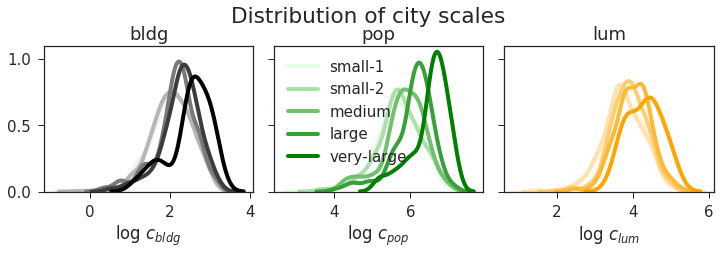

In [384]:
sns.set_context("notebook", font_scale=1.5)

fig, ax = plt.subplots(1,3, figsize=(12,3),
                      gridspec_kw={"wspace":0.1, "hspace":0.25},
                      sharex=False, sharey=True)

for a,c in zip(ax.flatten(), ["bldg", "pop", "lum"]):
    for i,l in enumerate(['small-1', 'small-2', 'medium', 'large', 'very-large']):
        cmap = sns.light_palette(colormap[c], n_colors=5)
        sns.kdeplot(np.log10(scales_df[c][scales_df['class']==l].values), ax=a, 
                    color=cmap[i], label=l if c=="pop" else None, lw=4)
    a.set_title(c)
    a.set_xlabel("log $c_{%s}$"%c)
a.legend(loc="best") #, bbox_to_anchor=(1.1, 1.05))
fig.subplots_adjust(top=0.8)
fig.suptitle("Distribution of city scales")
plt.ylim((0,1.1))

(0, 1)

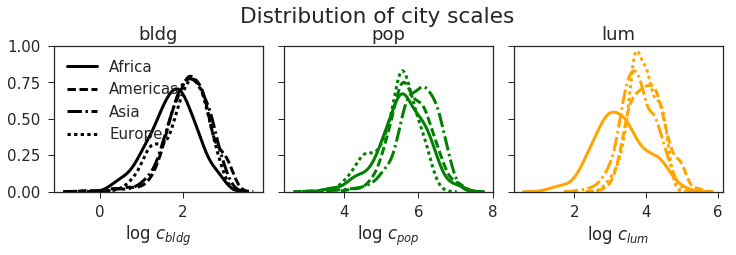

In [385]:
sns.set_context("notebook", font_scale=1.5)

fig, ax = plt.subplots(1,3, figsize=(12,3),
                      gridspec_kw={"wspace":0.1, "hspace":0.25},
                      sharex=False, sharey=True)

line_styles = ['-', '--', '-.', ':']
for a,c in zip(ax.flatten(), ["bldg", "pop", "lum"]):
    for i,l in enumerate(['Africa', 'Americas', 'Asia', 'Europe']):
        sns.kdeplot(np.log10(scales_df[c][scales_df['region']==l].values), ax=a, 
                    color=colormap[c], label=l if c=="bldg" else None, 
                    lw=3, linestyle=line_styles[i])
    a.set_title(c)
    a.set_xlabel("log $c_{%s}$"%c)
a.legend(loc="best") #, bbox_to_anchor=(1.1, 1.05))
fig.subplots_adjust(top=0.8)
fig.suptitle("Distribution of city scales")
plt.ylim((0,1))

(0, 1.2)

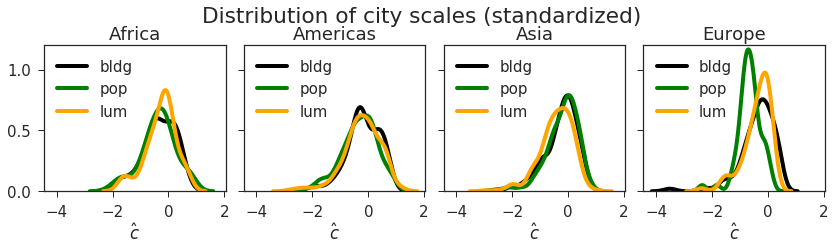

In [386]:
sns.set_context("notebook", font_scale=1.5)

fig, ax = plt.subplots(1,4, figsize=(14,3),
                      gridspec_kw={"wspace":0.1, "hspace":0.25},
                      sharex=True, sharey=True)

for a,l in zip(ax.flatten(), ['Africa', 'Americas', 'Asia', 'Europe']):
    for c in ["bldg", "pop", "lum"]:
        cur_df = scales_std_df[c][scales_std_df['region']==l]
        sns.kdeplot(np.log10(cur_df.values), ax=a, 
                    color=colormap[c], label=c, lw=4)
    a.set_title(l)
    a.set_xlabel("$\hat c$")
a.legend(loc="best") #, bbox_to_anchor=(1.1, 1.05))
fig.subplots_adjust(top=0.8)
fig.suptitle("Distribution of city scales (standardized)")
plt.ylim((0,1.2))

Look at "per-built-area" normalized population and luminosity scales. 

(0, 2.5)

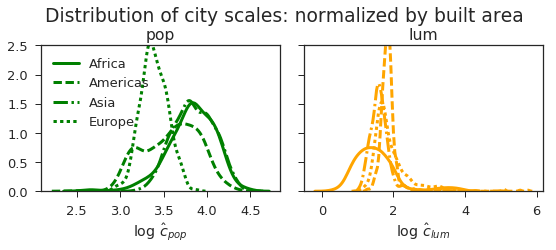

In [387]:
sns.set_context("notebook", font_scale=1.3)

fig, ax = plt.subplots(1,2, figsize=(9,3),
                      gridspec_kw={"wspace":0.1, "hspace":0.25},
                      sharex=False, sharey=True)

line_styles = ['-', '--', '-.', ':']
for a,c in zip(ax.flatten(), ["pop", "lum"]):
    for i,l in enumerate(['Africa', 'Americas', 'Asia', 'Europe']):
        sns.kdeplot(np.log10(scales_norm_df[c][scales_norm_df['region']==l].values), ax=a, 
                    color=colormap[c], label=l if c=="pop" else None, 
                    lw=3, linestyle=line_styles[i])
    a.set_title(c)
    a.set_xlabel("log $\hat c_{%s}$"%c)
a.legend(loc="best") #, bbox_to_anchor=(1.1, 1.05))
fig.subplots_adjust(top=0.8)
fig.suptitle("Distribution of city scales: normalized by built area")
plt.ylim((0,2.5))

Let's segment the built-area normalized city scales into _low_, _medium_, and _high_ categories by the percentiles of the marginal distributions for population and density.

In [388]:
q_pop = np.percentile(scales_norm_df['pop'], (0,25, 75,100))
q_lum = np.percentile(scales_norm_df['lum'], (0,25, 75,100))
classes = ['low', 'med', 'hi']
scales_norm_df['scale'] = ''
for p in range(3):
    for l in range(3):
        idx = (scales_norm_df['pop']>=q_pop[p]) & (scales_norm_df['pop']<=q_pop[p+1]) & \
              (scales_norm_df['lum']>=q_lum[l]) & (scales_norm_df['lum']<=q_lum[l+1])
        scales_norm_df.ix[idx,'scale'] = "pop-%s,lum-%s" % (classes[p], classes[l])
scales_norm_df['scale'].value_counts()        
        

pop-med,lum-med    638
pop-low,lum-med    328
pop-med,lum-low    315
pop-med,lum-hi     309
pop-hi,lum-med     296
pop-hi,lum-low     233
pop-low,lum-hi     220
pop-hi,lum-hi      103
pop-low,lum-low     84
Name: scale, dtype: int64

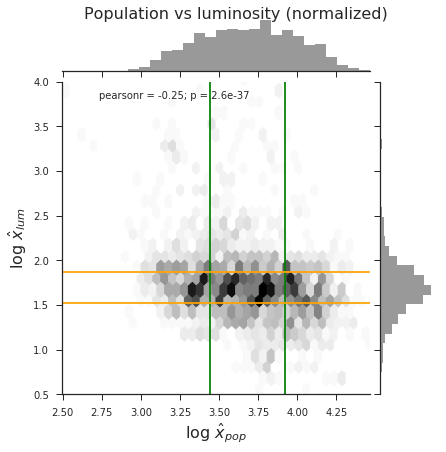

In [389]:
sns.set_context("notebook", font_scale=1.5)
sns.set(style="ticks")

plt.figure(figsize=(6,4))
g = sns.jointplot(np.log10(scales_norm[:,0]), np.log10(scales_norm[:,1]),
              kind="hex", color="black", ylim=(0.5,4))
g.fig.suptitle("Population vs luminosity (normalized)", fontsize=16)
g.ax_joint.set_xlabel("log $\hat x_{pop}$", fontsize=16)
g.ax_joint.set_ylabel("log $\hat x_{lum}$", fontsize=16)

for q in q_pop[1:-1]:
    g.ax_joint.axvline(x=np.log10(q), color=colormap["pop"])
    
for q in q_lum[1:-1]:
    g.ax_joint.axhline(y=np.log10(q), color=colormap["lum"])
    
    

# Estimate spatial gradient by linear regression

In [392]:
from scipy.stats import linregress

def f_ols(y):
    g, c, R, p, s = linregress(xtick_labels,y)
    return g, c, R**2, p, s

# population

grad_pop = map(f_ols, Xpop_hat_log)
grad_pop = pd.DataFrame(grad_pop, 
                        columns=["slope", "intercept", "rvalue", "pvalue", "stderr"])
grad_pop = pd.concat([info_df, grad_pop], axis=1)
# grad_pop[grad_pop['pvalue']<0.1] = 0

# luminosity

grad_lum = map(f_ols, Xlum_hat_log)
grad_lum = pd.DataFrame(grad_lum, 
                        columns=["slope", "intercept", "rvalue", "pvalue", "stderr"])
grad_lum = pd.concat([info_df, grad_lum], axis=1)

# buildings

grad_bld = map(f_ols, Xbld_hat_log)
grad_bld = pd.DataFrame(grad_bld, 
                        columns=["slope", "intercept", "rvalue", "pvalue", "stderr"])
grad_bld = pd.concat([info_df, grad_bld], axis=1)


grad_pop.head()

,city,class,region,slope,intercept,rvalue,pvalue,stderr
0,"achalpur, in (pop 111.3k)",small-1,Asia,-0.004780,-4.519864,0.153052,0.088067,0.002650
1,"san carlos de bariloche, ar (pop 110.0k)",small-1,Americas,-0.010226,-4.563558,0.107482,0.158211,0.006946
2,"la ceiba, hn (pop 130.2k)",small-1,Americas,-0.007030,-4.093327,0.155871,0.084938,0.003856
3,"turhal, tr (pop 110.9k)",small-1,Asia,-0.002915,-4.865644,0.030051,0.464838,0.003903
4,"matsusaka, jp (pop 124.6k)",small-1,Asia,-0.004678,-4.989679,0.051863,0.334219,0.004714


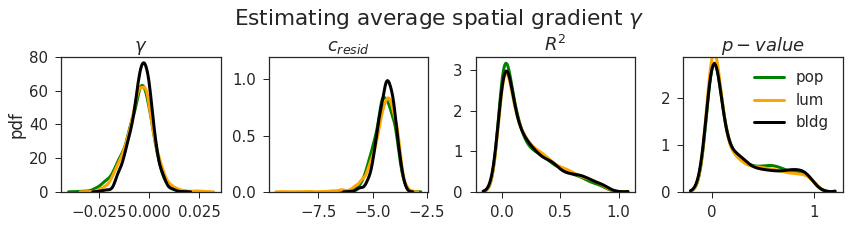

In [413]:
sns.set_context("notebook", font_scale=1.5)

fig, ax = plt.subplots(1,4, figsize=(14,3),
                      gridspec_kw={"wspace":0.3, "hspace":0.25},
                      sharex=False, sharey=False)
for df,c in zip([grad_pop, grad_lum, grad_bld], ['pop', 'lum', 'bldg']):
    sns.kdeplot(df['slope'].values, ax=ax[0], color=colormap[c], lw=3)
    sns.kdeplot(df['intercept'].values, ax=ax[1], color=colormap[c], lw=3)
    sns.kdeplot(df['rvalue'].values, ax=ax[2], color=colormap[c], lw=3)
    sns.kdeplot(df['pvalue'].values, ax=ax[3], color=colormap[c], label=c, lw=3)

ax[0].set_ylabel("pdf")
ax[0].set_title("$\gamma$"); ax[0].set_ylim((0,80))
ax[1].set_title("$c_{resid}$"); ax[1].set_ylim((0,1.2))
ax[2].set_title("$R^2$")
ax[3].set_title("$p-value$")
fig.subplots_adjust(top=0.75)
fig.suptitle("Estimating average spatial gradient $\gamma$")

Look at how $\gamma$ varies across geographical regions.

(0, 80)

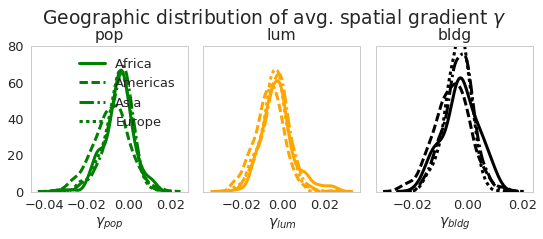

In [461]:
sns.set_context("notebook", font_scale=1.3)

fig, ax = plt.subplots(1,3, figsize=(9,3),
                      gridspec_kw={"wspace":0.1, "hspace":0.25},
                      sharex=False, sharey=True)

line_styles = ['-', '--', '-.', ':']
for a,c,df in zip(ax.flatten(), ["pop", "lum", "bldg"], [grad_pop, grad_lum, grad_bld]):
    for i,l in enumerate(['Africa', 'Americas', 'Asia', 'Europe']):
        sns.kdeplot(df[df['region']==l]['slope'].values, ax=a, 
                    color=colormap[c], label=l if c=="pop" else None, 
                    lw=3, linestyle=line_styles[i])
    a.set_title(c)
    a.set_xlabel("$\gamma_{%s}$"%c)
ax[2].legend(loc="best", bbox_to_anchor=(1.1, 1.05))
fig.subplots_adjust(top=0.8)
fig.suptitle("Geographic distribution of avg. spatial gradient $\gamma$")
plt.ylim((0,80))

Let's plot the $\gamma$s on a map to see any spatial patterns.

In [431]:
grad_pop_gdf = gpd.GeoDataFrame(pd.merge(grad_pop, cities_sel_df[['City', 'geometry']], 
                        left_on="city", right_on="City"))
grad_lum_gdf = gpd.GeoDataFrame(pd.merge(grad_lum, cities_sel_df[['City', 'geometry']], 
                        left_on="city", right_on="City"))
grad_bld_gdf = gpd.GeoDataFrame(pd.merge(grad_bld, cities_sel_df[['City', 'geometry']], 
                        left_on="city", right_on="City"))
grad_pop_gdf.head(2)

,city,class,region,slope,intercept,rvalue,pvalue,stderr,City,geometry
0,"achalpur, in (pop 111.3k)",small-1,Asia,-0.004780,-4.519864,0.153052,0.088067,0.002650,"achalpur, in (pop 111.3k)",POINT (77.508611 21.257222)
1,"san carlos de bariloche, ar (pop 110.0k)",small-1,Americas,-0.010226,-4.563558,0.107482,0.158211,0.006946,"san carlos de bariloche, ar (pop 110.0k)",POINT (-71.30136899999999 -41.140293)


In [ ]:
sns.set_context('notebook', font_scale=1.5)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(1,3,gridspec_kw={"wspace":0.03, "hspace":0.13},
                           figsize=(16,4), sharex=True, sharey=True)
for c,cur_gdf,a in zip(['pop', 'lum', 'bldg'], [grad_pop_gdf, grad_lum_gdf, grad_bld_gdf], ax.flatten()):
    world.plot(ax=a, color=[0.9,0.9,0.9,0.2], edgecolor=[0.8,0.8,0.8,0.9])
    cur_gdf.plot(ax=a, marker='.', 
                 column="slope",
                 cmap=cmap_dict[c], 
                 markersize=6, alpha=0.9)
    a.set_title("$\gamma_{%s}$"%c)
fig.subplots_adjust(top=0.95)
fig.suptitle("Communities of Metropolitan Regions: Detail View")


# Cluster cities by spatial profiles

The examples above invite the following questions:
* can we identify "classes" of cities by their general macroeconomic urban form (population density, built area density, luminosity), as described by the average profiles $\hat{x}_\cdot (d)$?
* how do we model the large amount of variance around these profiles observed in the real data? In particular, can we arrive at a 'functional' model that can, in practice, emulate the real data without the need of complex modeling assumptions?

#### Find optimum number of clusters via gap statistic

In [302]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from numpy.random import random_sample
from math import sqrt, log

# returns series of random values sampled between min and max values of passed col
def get_rand_data(col):
	rng = col.max() - col.min()
	return pd.Series(random_sample(len(col))*rng + col.min())

def iter_kmeans(df, n_clusters, num_iters=10):
    rng =  range(1, num_iters + 1)
    vals = pd.Series(index=rng)
    for i in rng:
        k = KMeans(n_clusters=n_clusters, n_init=10)
        k.fit(df)
        # print "Ref k: %s" % k.get_params()['n_clusters']
        vals[i] = k.inertia_
    return vals

def gap_statistic(df, max_k=10):
    gaps = pd.Series(index = range(1, max_k + 1))
    for k in range(1, max_k + 1):
        print k,
        km_act = KMeans(n_clusters=k, n_init=10, n_jobs=-1)
        km_act.fit(df)

        # get ref dataset
        ref = df.apply(get_rand_data)
        ref_inertia = iter_kmeans(ref, n_clusters=k).mean()

        gap = log(ref_inertia - km_act.inertia_)

        # print "Ref: %s   Act: %s  Gap: %s" % ( ref_inertia, km_act.inertia_, gap)
        gaps[k] = gap
    print "Done!"

    return gaps

In [130]:
# gap statistic analysis to find optimum number of clusters

# population profiles
gaps_pop = gap_statistic(pd.DataFrame(Xpop_log), max_k=25)
K_pop = np.argmax(gaps_pop)

# luminosity profiles
gaps_lum = gap_statistic(pd.DataFrame(Xlum_log), max_k=25)
K_lum = np.argmax(gaps_lum)

# building density profiles
gaps_bld = gap_statistic(pd.DataFrame(Xbld_log), max_k=25)
K_bld = np.argmax(gaps_bld)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 Done!
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 Done!
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 Done!


In [ ]:
# building density profiles
gaps_all = gap_statistic(pd.DataFrame(Xall), max_k=25)
K_all = np.argmax(gaps_all)

1 2 3 4 5 6 7

In [ ]:
K_pop, K_lum, K_bld, K_all

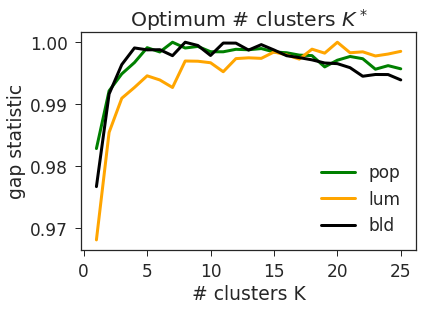

In [131]:
plt.figure(figsize=(6,4))
plt.plot(gaps_pop/gaps_pop.max(), lw=3, label="pop", color=colormap['pop'])
plt.plot(gaps_lum/gaps_lum.max(), lw=3, label="lum", color=colormap['lum'])
plt.plot(gaps_bld/gaps_bld.max(), lw=3, label="bld", color=colormap['bldg'])
# plt.plot(gaps_all/gaps_all.max(), lw=3, label="all", color='blue')
plt.title("Optimum # clusters $K^*$")
plt.xlabel("# clusters K")
plt.ylabel("gap statistic")
plt.legend(loc="best")
plt.show()


#### Cluster profiles and plot cluster centers

In [111]:
def clustering_analysis(X, text, K=4, nrow=1, figsize=(10,3), top=0.75):
    L = len(xtick_labels)
    n_curves = X.shape[1] / L

    # k-means clustering
    
    kmeans_mod = KMeans(n_clusters=K, n_init=100)
    C = kmeans_mod.fit_predict(X).astype(int)
    centroids = kmeans_mod.cluster_centers_

    clust_sizes = pd.Series(C).value_counts()
    plt.figure(figsize=(6,4))
    ax = clust_sizes.plot(kind="bar")
    ax.set_title("Cluster size: $x_{%s}(d)$"%"+".join(text), fontsize=20)
    ax.set_xlabel("Cluster ID")
    ax.set_ylabel("count")
    plt.show()
    
    sns.set_context("notebook", font_scale=1.7)

    nx = nrow
    ny = K / nx
    fig, ax = plt.subplots(nx,ny, 
                           gridspec_kw={"wspace":0.045, "hspace":0.3},
                           figsize=figsize, sharex=True, sharey=True)
    if len(ax.shape)==1:
        ax = np.expand_dims(ax, axis=0)
    for k,a in zip(range(K), ax.flatten()):
        idx = np.where(C == k)[0]
        for n in range(n_curves):
            std = X[idx,(n*L):((n+1)*L)].std(0)
            s = text if type(text)==str else text[n]
            a.plot(xtick_labels, centroids[k,(n*L):((n+1)*L)], lw=3, color=colormap[s])
            a.fill_between(xtick_labels,
                           np.maximum(centroids[k,(n*L):((n+1)*L)]-1.96*std,0), 
                           np.minimum(centroids[k,(n*L):((n+1)*L)]+1.96*std,1), 
                           color=colormap[s], alpha=0.3)
        # a.axis("off")
        a.set_title("C%d: %2.1f%%"%(k,100*float(clust_sizes[k])/clust_sizes.sum()))
        if k / nx == nx-1:
            a.set_xlabel("d [km]")
            a.set_xticks(xtick_labels[::6])
            a.set_xticklabels(xtick_labels[::6], rotation=30)

    plt.suptitle("Clustering cities by $x_{%s}(d)$"%"+".join(text))
    fig.subplots_adjust(top=top)
    plt.show()
    
    return C, centroids

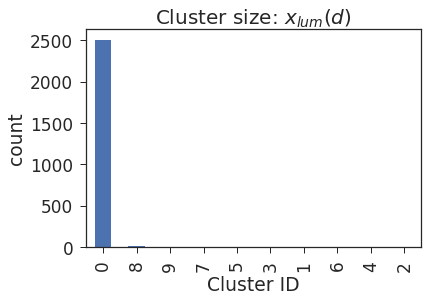

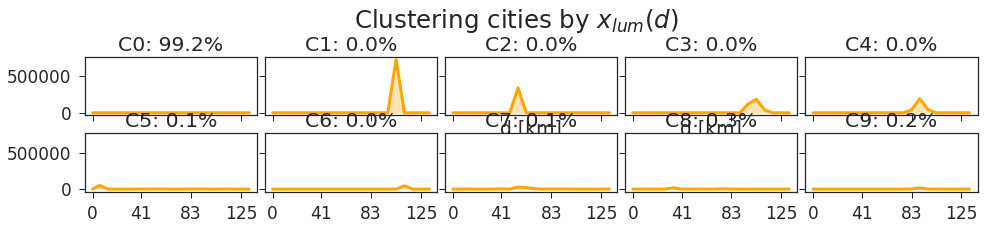

In [122]:
C_lum, cntr_lum = clustering_analysis(Xlum_norm, ["lum"], K=10, 
                                      nrow=2, figsize=(16,3), top=0.75)

city2clust_lum = dict(zip([k for k,v in cities_sel.iteritems()], C_lum))

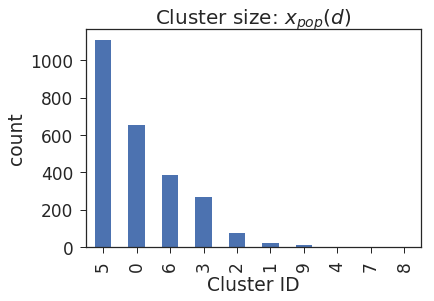

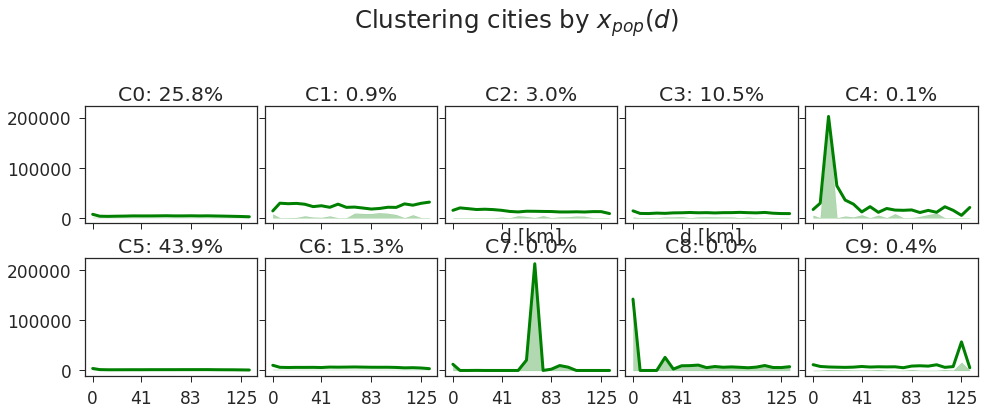

In [123]:
C_pop, cntr_pop = clustering_analysis(Xpop_norm, ["pop"], 10, \
                                      nrow=2, figsize=(16,6))

city2clust_pop = dict(zip([k for k,v in cities_sel.iteritems()], C_pop))

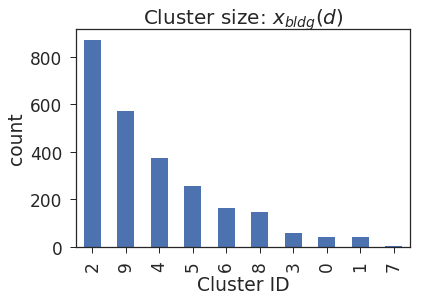

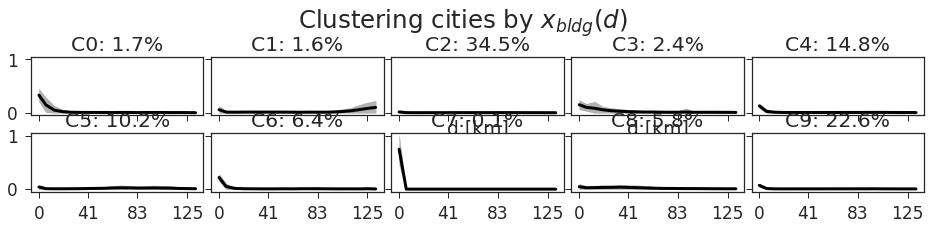

In [116]:
C_bld, cntr_bld = clustering_analysis(Xbld, ["bldg"], K=10, \
                                      nrow=2, figsize=(16,3))

city2clust_bld = dict(zip([k for k,v in cities_sel.iteritems()], C_bld))

In [ ]:
C_all, cntr_all = clustering_analysis(Xall, ["bldg", "pop", "lum"], \
                                      K=K_all, \
                                      nrow=3, figsize=(12,8), top=0.85)

city2clust_all = dict(zip([k for k,v in cities_sel.iteritems()], C_all))

#### Combine luminosity & population clusters

In [ ]:
clust_cross = (pd.crosstab(C_bld, [C_lum, C_pop], colnames=["lum", "pop"],\
                rownames=["bld"]).astype(float) / len(C_pop) * 100).round(1)

clust_cross

In [ ]:
(clust_cross >= 1).sum().sum(), clust_cross[(clust_cross >= 1)].sum().sum()

In [ ]:
cols_lp = clust_cross.columns.values
k_bld, k_lp = np.where(clust_cross>=1)
k_lum = [cols_lp[c][0] for c in k_lp]
k_pop = [cols_lp[c][1] for c in k_lp]

nx = 5
ny = len(k_pop) / nx

sns.set_context("notebook", font_scale=1.5)

fig, ax = plt.subplots(nx,ny, gridspec_kw={"wspace":0.03, "hspace":0.25},
                       figsize=(18,10), sharex=True, sharey=True)

for k,(kb,kp,kl) in enumerate(zip(k_bld, k_pop, k_lum)):
    a = ax[k%nx,k/nx]
    # plot building centroid
    idx_bld = np.where(C_bld == kb)[0]
    std = Xbld[idx_bld,:].std(0)
    a.plot(xtick_labels, cntr_bld[kb,:], lw=3, color=colormap['bldg'], 
           label="bld: C%d"%kb)
    a.fill_between(xtick_labels,
                   cntr_bld[kb,:]-2*std, 
                   cntr_bld[kb,:]+2*std, 
                   color=colormap['bldg'], alpha=0.3)
    # plot population centroid
    idx_pop = np.where(C_pop == kp)[0]
    std = Xpop[idx_pop,:].std(0)
    a.plot(xtick_labels, cntr_pop[kp,:], lw=3, color=colormap['pop'], 
           label="pop: C%d"%kp)
    a.fill_between(xtick_labels,
                   cntr_pop[kp,:]-2*std, 
                   cntr_pop[kp,:]+2*std, 
                   color=colormap['pop'], alpha=0.3)
    # plot luminosity centroid
    idx_lum = np.where(C_lum == kl)[0]
    std = Xlum[idx_lum,:].std(0)
    a.plot(xtick_labels, cntr_lum[kl,:], lw=3, color=colormap['lum'], 
           label="lum: C%d"%kl)
    a.fill_between(xtick_labels,
                   cntr_lum[kl,:]-2*std, 
                   cntr_lum[kl,:]+2*std, 
                   color=colormap['lum'], alpha=0.3)
    # a.axis("off")
    a.set_title("C%d: %2.1f%%"%(k,clust_cross.ix[kb,(kl,kp)]))
    if (k+1) % nx == 0:
        a.set_xlabel("d [km]")
        a.set_xticks(xtick_labels[::5])
        a.set_xticklabels(xtick_labels[::5], rotation=30)
    a.legend(loc="best")
        
plt.suptitle("City clusters by $x_{bld,pop,lum}(d)$", fontsize=20)
fig.subplots_adjust(top=0.85)
plt.show()


# Analyze variance in profiles ("signal to noise")

There is much more to the spatial distribution of macroeconomic quantities than the simple average profile with distance from the city centre. We analyze how this variance behaves across the world and different continents.

In [ ]:
Sbld = np.vstack([v['profiles']['bldg'][1] for k,v in cities_sel.iteritems()])
Spop = np.vstack([v['profiles']['pop'][1] for k,v in cities_sel.iteritems()])
Slum = np.vstack([v['profiles']['lum'][1] for k,v in cities_sel.iteritems()])

Rbld = Sbld / (Xbld)
Rpop = Spop / (Xpop)
Rlum = Slum / (Xlum)

In [ ]:
sns.set_context("notebook", font_scale=1.5)

fig, ax = plt.subplots(1,3, figsize=(16,4),
                      gridspec_kw={"wspace":0.1, "hspace":0.25},
                      sharex=True, sharey=False)

cmap_bld = sns.light_palette("black", n_colors=Rbld.shape[1])
cmap_pop = sns.light_palette("green", n_colors=Rbld.shape[1])
cmap_lum = sns.light_palette("orange",n_colors=Rbld.shape[1])
for i in np.arange(1,Rbld.shape[1],3):
    sns.kdeplot(Rbld[:,i], ax=ax[0], color=cmap_bld[i], label="%d km"%(i*2.86))
    sns.kdeplot(Rpop[:,i], ax=ax[1], color=cmap_pop[i])
    sns.kdeplot(Rlum[:,i], ax=ax[2], color=cmap_lum[i])
    
ax[0].set_title("Building density"); 
ax[1].set_title("Population density")
ax[2].set_title("Luminosity")

ax[0].set_xlabel("$var \ [x_{bld}]/\hat{x}_{bld}(d)$")
ax[1].set_xlabel("$var \ [x_{pop}]/\hat{x}_{pop}(d)$")
ax[2].set_xlabel("$var \ [x_{lum}]/\hat{x}_{lum}(d)$")

fig.subplots_adjust(top=0.75)
plt.suptitle("Variance to mean ratio dependence with distance")

In [ ]:
Rbld_df = pd.DataFrame(Rbld)
Rbld_df['region'] = [v['region'] for k,v in cities_sel.iteritems()]
Rbld_df['city'] = [v['city'] for k,v in cities_sel.iteritems()]
Rbld_df = pd.melt(Rbld_df, id_vars=["region", "city"])

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

plt.figure(figsize=(12,4))
g = sns.boxplot(data=Rbld_df, hue="region",
                y="value", x="variable", showfliers=False)
_ = g.set_xticklabels(((10*200./286)*np.arange(20)).astype(int), 
                      rotation=90)
g.set_xlabel("distance from city center $d$ [km]")
g.set_ylabel("$var \ [x_{bld}]/\hat{x}_{bld}(d)$")
g.set_title("Distance dependence of variance to mean ratio: building density")

There is significant variance in the spatial distributions of all three quantities studied. The variance increases with the distance from city center, but there may be many factors as to why that is the case. We don't have data to carefully model every key aspect. Yet, we'd like to be able to perform case studies and scenario analyses with realistic simulations. This suggests that a model with high capacity (a neural network) is suited for such an analysis.

# Illustrate example cities in each class

#### Read in all image source paths

In [ ]:
import glob

files = glob.glob(dataroot + "urban_areas_over_10kpop_log/*.png")
files_df = []
for f in files:
    s = f.split("/")
    fname = s[-1]
    cls = fname.split("_")[3]
    _,country,city,_,pop,lat,lon = fname.split("_")
    files_df.append((f, cls, country, pop))
    
files_df = pd.DataFrame(files_df, \
                columns=["filename", "class", "country", "population"])
files_df['city'] = files_df['filename'].apply(lambda s: os.path.basename(s).split("_")[2].replace("-"," "))
files_df['source'] = files_df['filename'].apply(lambda s: os.path.basename(s).split("_")[0])

files_df = files_df[files_df['city'].isin(cities_sel.keys())]

sources = files_df.groupby("city").apply(\
                    lambda x: (x[['city', 'country', 'population', 'class']].iloc[0].to_dict(), 
                               dict(zip(x['source'], x['filename']))))
sources = dict(zip(sources.index.tolist(), sources.values.tolist()))

print len(sources)

In [ ]:
mysrc = sources.values()[290]
mysrc

#### Make example canvass to plot for each 

In [ ]:
from skimage.transform import resize
from skimage.io import imread, imsave

def read_img(f, imgSize=None):
    img = imread(f)
    if imgSize is not None:
        img = resize(img, (imgSize, imgSize), preserve_range=True)
    img = (img - img.min()) / float((img.max() - img.min()))
    return img

def concat_sources(src):
    i0 = read_img(src[1]['POP'])
    i1 = read_img(src[1]['NLI'])
    i2 = read_img(src[1]['SAR'])
    mask = i0==0
    img= np.zeros(i1.shape+(3,))
    img[:,:,0] = i0; img[:,:,1] = i1; img[:,:,2] = i2;
    img[mask] = 0
    return img

In [ ]:
img = concat_sources(mysrc)
plt.imshow(img)

In [ ]:
def make_canvass(image_paths, labels, nExamples=10, thumbSize = (64,64,3), pad_pix=2, title="example"):
    
    clustLabels = np.unique(labels)
    nClusters = clustLabels.size
    canvas = np.ones(((thumbSize[0]+pad_pix)*nClusters, nExamples*(thumbSize[1]+pad_pix), 3))
    for i,c in enumerate(clustLabels):
        cur_class_samples = np.where(labels==c)[0]
        idx = np.random.choice(cur_class_samples, replace=False, size=min([nExamples, len(cur_class_samples)]))
        for j in range(len(idx)):
            img = concat_sources(image_paths[idx[j]])
            img = resize(img, thumbSize, preserve_range=True)
            canvas[i*(thumbSize[0]+pad_pix):(i*pad_pix + (i+1)*thumbSize[0]), 
                   j*(thumbSize[1]+pad_pix):(j*pad_pix + (j+1)*thumbSize[1])] = img
    return canvas

In [ ]:
canvas = make_canvass(sources.values(), [city2clust_all[x] for x in sources.keys()])

In [ ]:
nClusters = len(np.unique(C_all))

# plot examples of each class
fig,ax = plt.subplots(1, figsize=(12,10))
plt.tight_layout()
print canvas.shape
ax.imshow(canvas.swapaxes(0,1))#, aspect='auto')
ax.set_title("Classes of cities: examples", fontsize=18)
ax.set_ylabel("-- examples --", fontsize=16)
ax.set_xlabel("-- classes --", fontsize=16)
# Turn off tick labels
ax.set_xticks([64 * (0.5 + x*1.03) + 2 for x in range(nClusters)])
ax.set_xticklabels(["C%d"%x for x in range(nClusters)], fontsize=16, rotation=90)
ax.set_yticklabels([])
# plt.axis("off")
plt.show()

#### Geographical distribution of clusters

In [ ]:
cities_gdf = gpd.GeoDataFrame(cities_sel_df)
#cities_gdf['geometry'] = cities_gdf['geometry'].apply(lambda s: shapely.wkt.loads(s))
cities_gdf['cluster'] = cities_gdf['City'].apply(lambda x: int(city2clust_all[x]) if x in city2clust_all else np.nan)
# cities_gdf.dropna(inplace=True)

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib

# define a custom color palette
my_colors = [
 (102, 48, 52),
 (218, 96, 75),
 (249, 171, 174),
 (179, 99, 149),
 # (215, 187, 208),
 # (218, 198, 199),
 (161, 185, 59),
 # (214, 227, 140),
 (255, 250, 182),
 (25, 101, 64),
 (189, 225, 237),
 (60, 60, 60)]

my_colors = [(np.array(v)/float(255)).tolist() + [1.0] for v in my_colors]

my_cmap = matplotlib.colors.ListedColormap(my_colors)

sns.palplot(sns.color_palette(my_colors))

In [ ]:
sns.set_context('notebook', font_scale=1.5)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ex_cities = 

fig, ax = plt.subplots(3,3,gridspec_kw={"wspace":0.03, "hspace":0.03},
                           figsize=(14,7), sharex=True, sharey=True)
for c,a in zip(range(K_all), ax.flatten()):
    world.plot(ax=a, color=[0.9,0.9,0.9,0.2], edgecolor=[0.8,0.8,0.8,0.9])
    cur_gdf = cities_gdf[cities_gdf['cluster']==c].sort_values("Population", ascending=False)
    cur_gdf.plot(ax=a, marker='.', color=my_colors[c], markersize=6, alpha=0.9)
    print "C%d:"%c, cur_gdf.head(3)['City'].values.tolist()
    a.annotate("C%d"%c, xy=(-140, -45))
plt.suptitle("Communities of Metropolitan Regions: Detail View")
fig.subplots_adjust(top=0.93)

In [ ]:
sns.set_context('notebook', font_scale=2)

ax = cities_gdf.plot(figsize=(20,6), marker='*', color='black', markersize=3)
for c,col in zip(range(K_all), my_colors):
    cities_gdf[cities_gdf['cluster']==c].plot(ax=ax, marker='.', color=col, markersize=6, alpha=0.9)
plt.title("Communities of Metropolitan Regions")
plt.xlabel("longitude")
plt.ylabel("latitude")

# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.835, 0.1, 0.03, 0.8])

# This function formatter will replace integers with target names
formatter = plt.FuncFormatter(lambda val, loc: "C%d"%val)

sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=matplotlib.colors.Normalize(0,8))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
sm.set_clim(-0.5, K_all-0.5)

# We must be sure to specify the ticks matching our target names
cb = fig.colorbar(sm, ticks=range(K_all), format=formatter, cax=cax);
cb.set_ticks(range(K_all))

# Relate clusters to macroeconomic data on cities

In this section, we analyze the relationship between several macroeconomic indicators measured at the level of cities or countries to the classes of urban form that the city belongs to. We use a discrete-choice modeling approach, where the dependent variable is the city class, and the independent variables (covariates) are the macroeconomic indicators. 

#### Integrate data at city level

In [ ]:
# load data on cities

attributes_df = pd.read_csv(dataroot + "cities_macroeconomic_data.csv")
attributes_df['city'] = attributes_df['city'].apply(\
                                        lambda x: re.sub(r' \([^)]*\)', '', x))
attributes_df = attributes_df.fillna(attributes_df.mean())
attributes_df.set_index("city", inplace=True)

with gzip.open(dataroot + "cities_macroeconomic_variables.pickle.gz", "r") as f:
    vars_dict = pickle.load(f)

print attributes_df.shape

attributes_df.head()

In [ ]:
# format cluster info: city level

clust_df = pd.DataFrame(np.vstack([C_pop, C_bld, C_lum, C_all]).T, \
                        columns=["pop", "bld", "lum", "all"], 
                        index=[v['city'] for k,v in cities_sel.iteritems()])
clust_df.index = [s.split("(")[0][:-1] for s in clust_df.index]

clust_df.head()

In [ ]:
city_data_df = attributes_df.join(clust_df)
city_data_df.dropna(inplace=True)
city_train_cols = attributes_df.columns.values.tolist() 
city_weights = np.ones(len(city_data_df))

#### Integrate data at country level

This kind of classification with "soft labels" is not supported in standard machine learning or statistics packages like `scikit-learn` or `statsmodels`. However, this is equivalent to a standard logistic regression, with weights on each sample corresponding to the soft label (between 0 and 1).

In [ ]:
# load data on countries

country_df = pd.read_csv(dataroot + "country_macro_indicators.csv")
country_df.set_index("code", inplace=True)
country_df.drop('CountryName', axis=1, inplace=True)
country_df = pd.get_dummies(country_df)
country_df.head()

In [ ]:
clust_df.head()

In [ ]:
# format cluster info: country level

clust_country_df = clust_df.reset_index().rename(columns={"index":"city"})
clust_country_df['country'] = clust_country_df['city'].apply(lambda x: x.split(",")[1][1:])
clust_country_df = clust_country_df[['country', "all"]]
# clust_country_df = pd.get_dummies(clust_country_df, columns=["all"])
# clust_country_df.columns = ['country'] + [i for i in range(clust_country_df.shape[1]-1)]
# clust_country_df = clust_country_df.groupby("country").apply(lambda x:  x.iloc[:,1:].sum(0)/float(len(x)))
# clust_country_df = pd.melt(clust_country_df.reset_index(), id_vars="country",
#                            var_name="cluster", value_name="weight")
# clust_country_df = clust_country_df[clust_country_df['weight']>0]
clust_country_df.rename(columns={"all":"cluster"}, inplace=True)
clust_country_df.set_index("country", inplace=True)
clust_country_df.head()

In [ ]:
country_data_df = country_df.join(clust_country_df)
country_data_df.dropna(inplace=True)
country_train_cols = country_df.columns.values.tolist() 

# country_weights = country_data_df['weight'].values
# country_data_df.drop("weight", axis=1, inplace=True)
country_weights = np.ones(len(country_data_df))

#### Perform analysis

Since we have so few data points (150) and relatively many features (40), let's first find the most important ones via a random forest classifier.

In [ ]:
data_df = country_data_df
X = country_data_df[country_train_cols].values
weights = country_weights
train_cols = country_train_cols

# X = city_data_df[city_train_cols].values

X = (X - X.mean(0)) / (X.std(0) + 1e-6)
X = np.hstack([X, np.ones((len(X),1))])
train_cols += ['intercept']

print X.shape, weights.shape

In [ ]:
import statsmodels.api as st
from sklearn.ensemble import RandomForestClassifier

def mnl_analysis(resp_col="pop", reg=0, top=10):
    y = data_df[resp_col].astype(str).values
    
    # select a few important variables
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X, y, weights)
    feat_imp = pd.Series(clf.feature_importances_)
    feat_imp.index = train_cols
    feat_imp.sort_values(ascending=False, inplace=True)
    feat_imp.head(top)[::-1].plot(kind='barh')
    imp_cols = feat_imp.head(top)[::-1].index.values.tolist() + ['intercept']
    print "top %d features: "% top, imp_cols
    
    mnl = st.MNLogit(y, X[:,[train_cols.index(c) for c in imp_cols]])
    mnl_fit = mnl.fit_regularized(alpha=reg)
    mnl_stats = mnl_fit.summary()

    # extract statistically-significant variables
    signif_vars_df = pd.DataFrame(mnl_fit.pvalues, index=imp_cols )
    idx_ok = (~signif_vars_df[signif_vars_df<0.05].isnull()).sum(1)>0
    signif_vars_df = signif_vars_df[idx_ok]
    signif_vars_df.index = [vars_dict[x] if x in vars_dict else x\
                            for x in signif_vars_df.index]
    signif_vars_df.columns = ["C%d"%(c+1) for c in signif_vars_df.columns]
    signif_vars_df = signif_vars_df.fillna(0)
    
    return signif_vars_df.ix[signif_vars_df.sum(1) > 0]

In [ ]:
signif_vars_all = mnl_analysis("cluster", reg=0.00)
signif_vars_pop

In [ ]:
sns.heatmap(signif_vars_pop, cmap="RdBu_r", center=0)

In [ ]:
signif_vars_bld = mnl_analysis("bld", reg=0.1)
signif_vars_bld

In [ ]:
signif_vars_lum = mnl_analysis("lum", reg=3)
signif_vars_lum

In [ ]:
signif_vars_all = mnl_analysis("all", reg=3.3)
signif_vars_all

# Scratch

In [ ]:
from sklearn import linear_model
from scipy import stats
import numpy as np

class LogisticRegression(linear_model.LogisticRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LogisticRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, weights, n_jobs=1):
        self = super(LogisticRegression, self).fit(X, y, weights, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([
            np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
                                                    for i in range(sse.shape[0])
                    ])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self